# A satellite view of the December 2017 Thomas Fire in California

Author: [Leonardo Uieda](https://www.leouieda.com/)

We'll use two Landsat 8 scenes from before and after the [Thomas Fire](https://en.wikipedia.org/wiki/Thomas_Fire). The scenes were downloaded from [USGS EarthExplorer](https://earthexplorer.usgs.gov/) (WRS row/path = `042/036`) and selected bands were uploaded as compressed archives to [figshare (doi:10.6084/m9.figshare.21930384)](https://doi.org/10.6084/m9.figshare.21930384) for archival and easier retrieval using [Pooch](https://www.fatiando.org/pooch). 

Let's get started!

## Import libraries

We'll use the following libraries to manipulate the data and make some nice figures:

* [matplotlib](https://matplotlib.org/): the most popular Python plotting library (for a good reason, it's awesome).
* [matplotlib-scalebar](https://pypi.org/project/matplotlib-scalebar/): to add a scale bar to matplotlib figures (a good map always has a scale).
* [xlandsat](https://www.compgeolab.org/xlandsat/): a library developed by us at the [CompGeoLab](https://www.compgeolab.org/) for loading the Landsat scenes into [xarray](https://xarray.dev/) and making composites.
* [pooch](https://www.fatiando.org/pooch): for downloading data from a variety of sources, including figshare DOIs.

In [1]:
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.gridspec import GridSpec
import xlandsat as xls
import pooch

## Download the archived data

First, we'll use [Pooch](https://www.fatiando.org/pooch) to download the archives with the scenes. The MD5 checksums were copied from the [figshare archive](https://doi.org/10.6084/m9.figshare.21677246) and are used by Pooch to verify if the download was successful. Both archives are around 500 Mb in size so this can take a little while depending on your internet connection.

In [2]:
doi = "10.6084/m9.figshare.21930384"
paths = {}
paths["before"] = pooch.retrieve(
    f"doi:{doi}/LC08_L2SP_042036_20171123_20200902_02_T1.tar.gz",
    known_hash="md5:b44d45833738f78c1499a400c6ad0039",
    progressbar=True,
)
paths["after"] = pooch.retrieve(
    f"doi:{doi}/LC08_L2SP_042036_20180126_20200902_02_T1.tar.gz",
    known_hash="md5:fd5961a9eee1bbd3a07cab8bf39efbb4",
    progressbar=True,
)
for date in paths:
    print(f"{date}: {paths[date]}")

before: /home/leo/.cache/pooch/bbc8c5572f333cba825ef7a1ecf7c773-LC08_L2SP_042036_20171123_20200902_02_T1.tar.gz
after: /home/leo/.cache/pooch/816a09f0006956c305f3a38a0c7bd13d-LC08_L2SP_042036_20180126_20200902_02_T1.tar.gz


## Load the scenes

Next, we'll use [xlandsat](https://www.compgeolab.org/xlandsat/) to load a section of the scenes into `xarray.Dataset` objects. We'll use the same region definition (in UTM coordinates) to make sure both scenes refer to exactly the same bounding box. This also helps keep the scenes a bit smaller in memory. The region was chosen to include the main area affected by the fire.

In [3]:
region = [250000, 325000, 3790000, 3832500]  # UTM West, East, South, North
scenes = {date: xls.load_scene(paths[date], region=region) for date in paths}
scenes["after"]

<xarray.Dataset>
Dimensions:   (easting: 2500, northing: 1417)
Coordinates:
  * easting   (easting) float64 2.5e+05 2.5e+05 2.501e+05 ... 3.25e+05 3.25e+05
  * northing  (northing) float64 3.79e+06 3.79e+06 ... 3.832e+06 3.832e+06
Data variables:
    blue      (northing, easting) float16 0.05322 0.0531 ... 0.08337 0.07141
    green     (northing, easting) float16 0.05029 0.05066 ... 0.1035 0.0885
    red       (northing, easting) float16 0.04565 0.04602 ... 0.1157 0.09583
    nir       (northing, easting) float16 0.04504 0.04529 ... 0.2013 0.1708
    swir1     (northing, easting) float16 0.04858 0.04846 ... 0.2037 0.173
    swir2     (northing, easting) float16 0.04883 0.04883 ... 0.1754 0.1461
    thermal   (northing, easting) float16 286.8 286.8 286.8 ... 288.5 287.8
Attributes: (12/19)
    Conventions:                CF-1.8
    title:                      Landsat 8 scene from 2018-01-26 (path/row=42/36)
    digital_object_identifier:  https://doi.org/10.5066/P9OGBGM6
    origin:                     Image courtesy of the U.S. Geological Survey
    landsat_product_id:         LC08_L2SP_042036_20180126_20200902_02_T1
    processing_level:           L2SP
    ...                         ...
    ellipsoid:                  WGS84
    date_acquired:              2018-01-26
    scene_center_time:          18:34:27.3161230Z
    wrs_path:                   42
    wrs_row:                    36
    mtl_file:                   GROUP = LANDSAT_METADATA_FILE\n  GROUP = PROD...

One of the nice things about `xlandsat` is that it will include a lot of the metadata from the scenes in the `xarray.Dataset` and set the proper UTM coordinates for each pixel. This allows `xarray` to automate a lot of the boring parts of creating figures (setting axis labels, etc).

## RGB composites

Let's make some RGB (AKA "true color") composites to get an idea of what's going on. Generating composites with `xlandsat` is easy and by default it will use the red, green, and blue bands of the scene. We can also apply some re-scaling of the reflectance of each band to increase the contrast and avoid having the clouds and human structures saturate the image.

In [4]:
rgb = {date: xls.composite(scenes[date], rescale_to=(0, 0.23)) for date in scenes}

/home/leo/bin/conda/envs/thomas-fire/lib/python3.10/site-packages/skimage/exposure/exposure.py:598: RuntimeWarning: invalid value encountered in cast
  return np.asarray(image * (omax - omin) + omin, dtype=out_dtype)
/home/leo/bin/conda/envs/thomas-fire/lib/python3.10/site-packages/skimage/exposure/exposure.py:598: RuntimeWarning: invalid value encountered in cast
  return np.asarray(image * (omax - omin) + omin, dtype=out_dtype)


The composite is an `xarray.DataArray` that includes the right coordinates and metadata. Plotting it is as easy as calling `rgb["2022-12-02"].plot.imshow()`. We'll use a bit more code here to plot both scenes in the same figure and tweak some of the plot elements, in particular making the pixels squared by setting `ax.set_aspect("equal")`. 

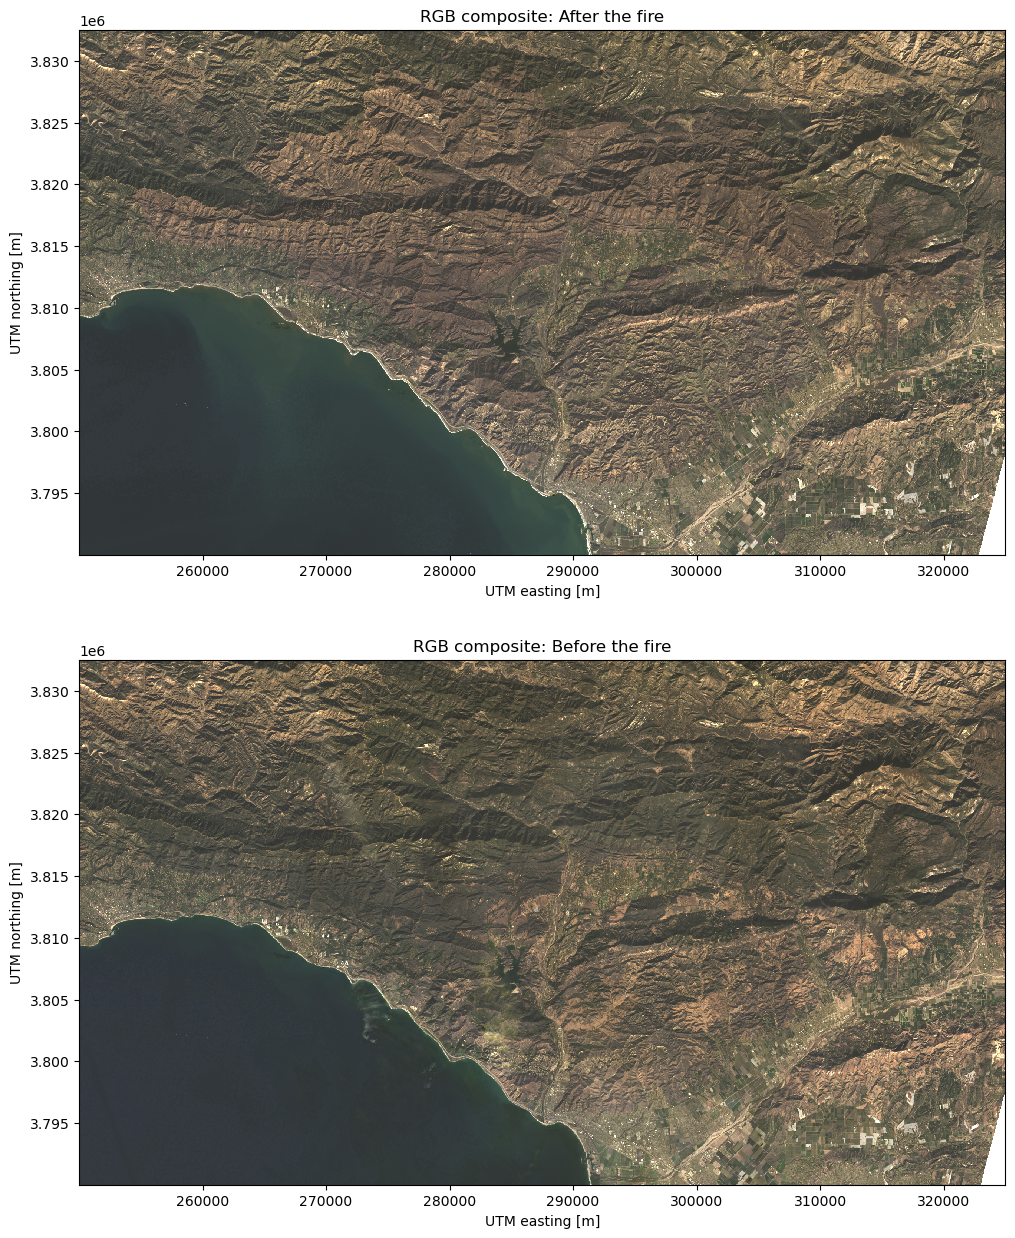

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(12, 15))
for date, ax in zip(sorted(scenes.keys()), axes):
    rgb[date].plot.imshow(ax=ax)
    ax.set_aspect("equal")
    ax.set_title(f"RGB composite: {date.capitalize()} the fire")
plt.show()

## NBR

Calculate the normalized burn ratio to get a better view of the burned area.

In [6]:
nbr = {
    date: (scenes[date].nir - scenes[date].swir2)/(scenes[date].nir + scenes[date].swir2) 
    for date in scenes
}

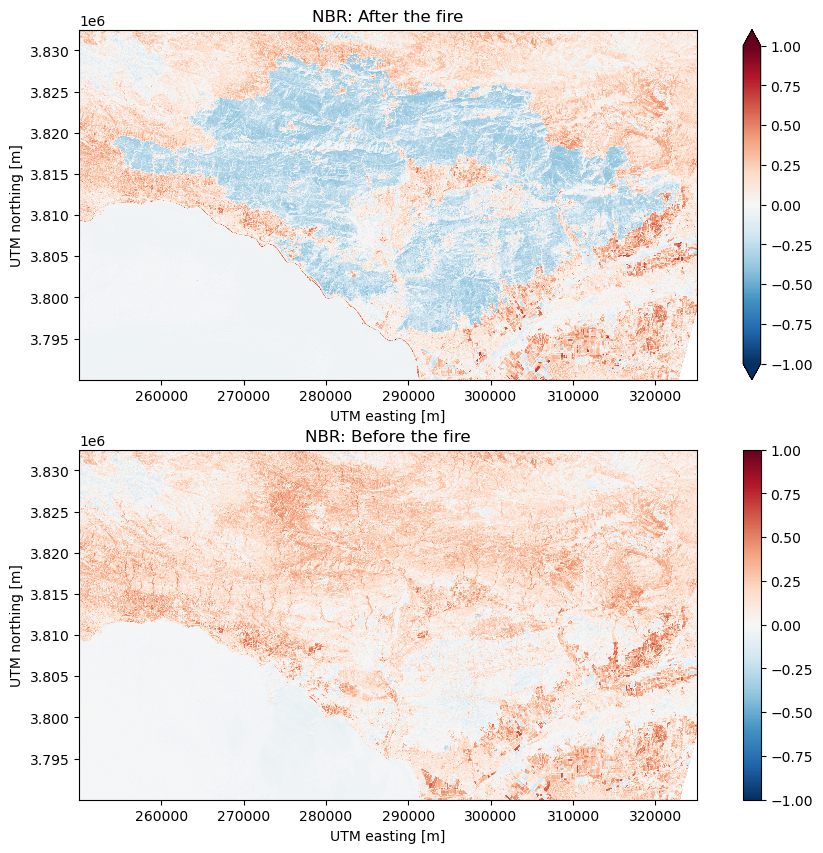

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
for date, ax in zip(sorted(scenes.keys()), axes):
    nbr[date].plot.imshow(ax=ax, vmin=-1, vmax=1, cmap="RdBu_r")
    ax.set_aspect("equal")
    ax.set_title(f"NBR: {date.capitalize()} the fire")
plt.show()

## Plot everything together

Now we can make some nicer figures, with a scale bar and a caption at the bottom.

/tmp/ipykernel_133372/2287914387.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0, w_pad=0, h_pad=0)


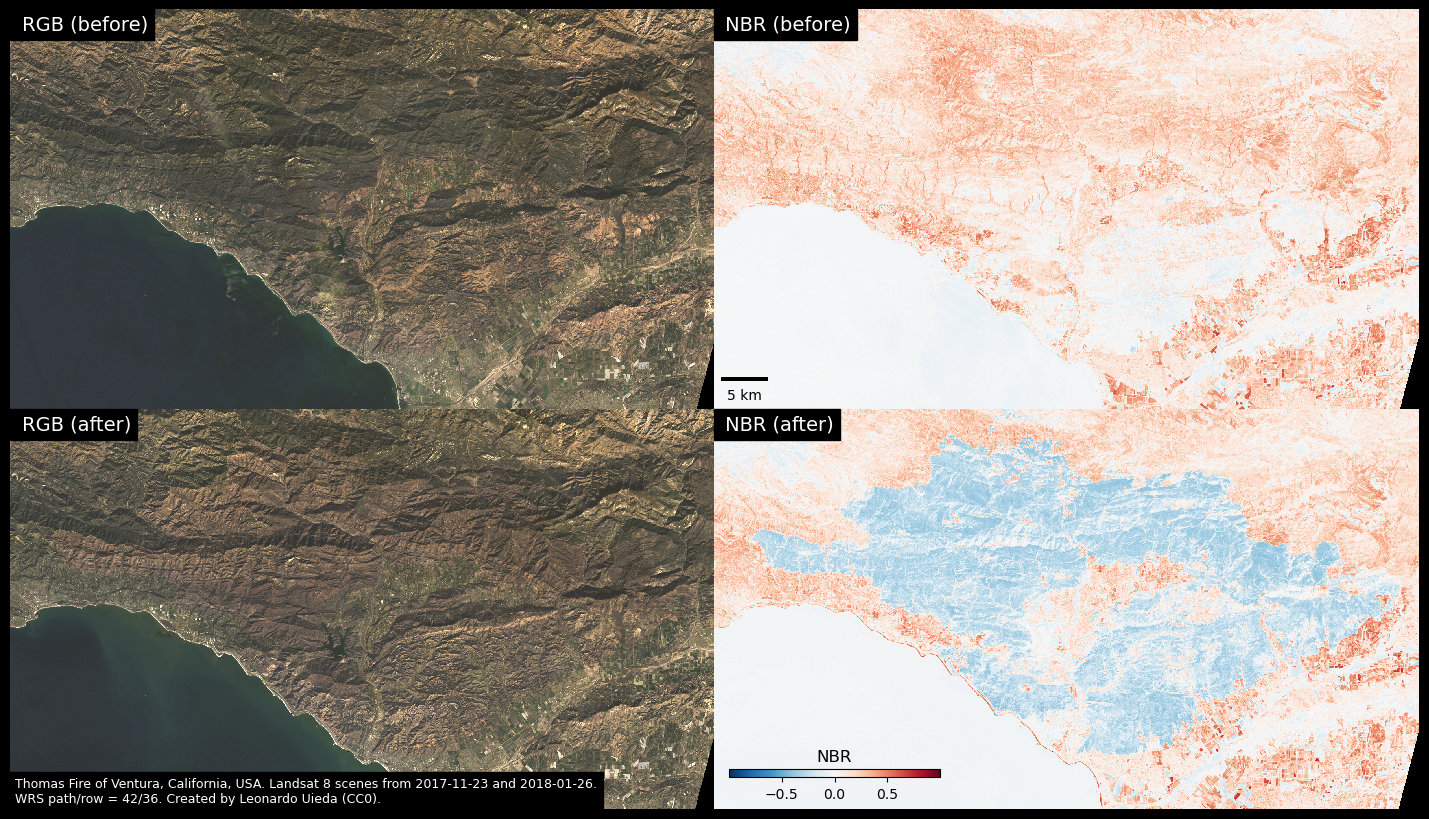

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14.1, 8), facecolor="black")
axes = axes.T.ravel()
for ax, date in zip(axes[:2], ["before", "after"]):
    rgb[date].plot.imshow(ax=ax)
    ax.text(
        0.008, 0.985,
        f" RGB ({date})", 
        color="white", 
        fontweight="normal", 
        fontsize=14,
        verticalalignment="top",
        backgroundcolor="black",
        transform=ax.transAxes,        
    )    
for ax, date in zip(axes[2:], ["before", "after"]):
    tmp = nbr[date].plot(ax=ax, vmin=-1, vmax=1, cmap="RdBu_r", add_colorbar=False)
    ax.text(
        0.008, 0.985,
        f" NBR ({date})", 
        color="white", 
        fontweight="normal", 
        fontsize=14,
        verticalalignment="top",
        backgroundcolor="black",
        transform=ax.transAxes,        
    )    
fig.colorbar(
    tmp, 
    cax=fig.add_axes([0.51, 0.04, 0.15, 0.01], title="NBR"), 
    orientation="horizontal", 
    ticks=[-0.5, 0, 0.5],
)
for ax in axes:
    ax.axis("off")
    ax.set_aspect("equal")
caption = (
    f" Thomas Fire of Ventura, California, USA. Landsat 8 scenes from "
    f"{scenes['before'].attrs['date_acquired']} and {scenes['after'].attrs['date_acquired']}.\n"
    f" WRS path/row = {scenes['after'].attrs['wrs_path']}/{scenes['after'].attrs['wrs_row']}. "
    "Created by Leonardo Uieda (CC0)."
)
fig.text(0.001, 0.005, 
    caption,
    color="white", 
    fontweight="normal", 
    fontsize=9,
    verticalalignment="bottom",
    backgroundcolor="black",
)
# Add a scale bar
axes[-2].add_artist(
    ScaleBar(
        dx=1, 
        units="m", 
        location="lower left", 
        box_alpha=0,
        color="black", 
        scale_loc="bottom", 
        width_fraction=0.01, 
        length_fraction=0.1,
        pad=0.4,
    )
)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
# Save the figure to JPG files at high and low resolution versions
for suffix, dpi in zip(["", "-low-res"], [600, 200]):
    plt.savefig(
        f"thomas-fire{suffix}.jpg", 
        bbox_inches="tight", 
        pad_inches=0, 
        dpi=dpi,
    )

## Save the cropped version of the scene

For use in teaching and examples, the cropped version if probably better. Let's save it back into a tar archive so that it looks like an EarthExplorer download.

In [10]:
for date in scenes:
    scene = scenes[date]
    xls.save_scene(f"{scene.attrs['landsat_product_id']}-cropped.tar.gz", scene)

## License

The original code source code for this can be found at the [`compgeolab/thomas-fire-landsat-2017` GitHub repository](https://github.com/compgeolab/thomas-fire-landsat-2017).
Comments, corrections, and additions are welcome.

All Python source code is made available under the [MIT license](https://github.com/compgeolab/thomas-fire-landsat-2017/blob/main/LICENSE). 
You can freely use and modify the code, without warranty, so long as you provide attribution to the authors.

All text and figures figures in this notebook are available under the [Creative Commons Public Domain Dedication (CC0)](https://creativecommons.org/publicdomain/zero/1.0/).